In [7]:
from os.path import expanduser, join
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

from black_box_tools.db_utils import DBUtils
from black_box_tools.data_utils import DataUtils, Filters
from black_box_tools.plot_utils import PlotUtils

In [8]:
def rescale(arr, arr_min=None, arr_max=None):
    new_arr = np.array(np.abs(arr))
    if arr_min is None:
        arr_min = np.min(new_arr, 0)
        arr_max = np.max(new_arr, 0)
    ranges = (arr_max - arr_min) + 1e-10
    for i in range(new_arr.shape[0]):
        new_arr[i] = (new_arr[i] - arr_min) / ranges
    new_arr = np.clip(new_arr, 0., 1.)
    return new_arr, arr_min, arr_max

def train(x, sequence_len):
    number_of_sequences = len(x) - sequence_len
    x, arr_min, arr_max = rescale(x)

    training_data = list()
    for i in range(number_of_sequences):
        training_data.append(x[i:i+sequence_len])
    training_data = np.array(training_data)

    network = DBN(sequence_len, [sequence_len*2])
    network.train(training_data, epochs=30, learning_rate=0.1)
    return network, arr_min, arr_max

def test(x, arr_min, arr_max, network, sequence_len):
    number_of_sequences = len(x) - sequence_len
    x, _, _ = rescale(x, arr_min, arr_max)

    test_data = list()
    for i in range(number_of_sequences):
        test_data.append(x[i:i+sequence_len])
    test_data = np.array(test_data)

    distances = list()
    for i in range(number_of_sequences):
        sample = network.sample_network(test_data[i, :])
        dist = distance(sample, test_data[i])
        distances.append(dist)

    return distances

def distance(x, y):
    return np.sqrt(np.sum(np.square(np.sqrt(x) - np.sqrt(y)))) / np.sqrt(2)

# Parameters

The following parameters should be set appropriately so that the correct data are read.

In [10]:
log_db_data_name = 'black_box_data'
faulty_log_db_data_name = 'faulty_black_box_data'
number_of_smart_wheels = 4

# Database restoring

In [4]:
DBUtils.restore_db('black_box_data/nominal_data/data',
                   db_name=log_db_data_name)

True

In [5]:
DBUtils.restore_db('black_box_data/faulty_data/data',
                   db_name=faulty_log_db_data_name)

True

# Data parsing

## Training and test data

The training data are the voltages from the first wheel of each smart wheel; the test data are all voltage measurements of the wheels (in this case, part of the test set is included in the training set, which is technically not a valid thing to do, but we still nevertheless want to check how the model performs on the training data as well).

In [11]:
sw_data_docs = DBUtils.get_all_docs(log_db_data_name,
                                    'ros_sw_ethercat_parser_data')
nominal_timestamps = DataUtils.get_all_measurements(sw_data_docs, 'timestamp')

# we extract all current measurements from the first wheel
train_data_sw1 = DataUtils.get_all_measurements(sw_data_docs,
                                                'sensors/0/current_1_q',
                                                data_filter=Filters.MEDIAN,
                                                filter_window_size=101)
train_data_sw2 = DataUtils.get_all_measurements(sw_data_docs,
                                                'sensors/1/current_1_q',
                                                data_filter=Filters.MEDIAN,
                                                filter_window_size=101)
train_data_sw3 = DataUtils.get_all_measurements(sw_data_docs,
                                                'sensors/2/current_1_q',
                                                data_filter=Filters.MEDIAN,
                                                filter_window_size=101)
train_data_sw4 = DataUtils.get_all_measurements(sw_data_docs,
                                                'sensors/3/current_1_q',
                                                data_filter=Filters.MEDIAN,
                                                filter_window_size=101)

data = np.vstack((train_data_sw1, train_data_sw2,
                  train_data_sw3, train_data_sw4))

var_names = ['current1', 'current2', 'current3', 'current4']
(corr_vars, windowed_correlations) = DataUtils.get_windowed_correlations(var_names, data, window_size=100)

In [12]:
corr_vars

[('current1', 'current2'),
 ('current1', 'current3'),
 ('current1', 'current4'),
 ('current2', 'current3'),
 ('current2', 'current4'),
 ('current3', 'current4')]

In [13]:
windowed_correlations.shape

(6, 1365)

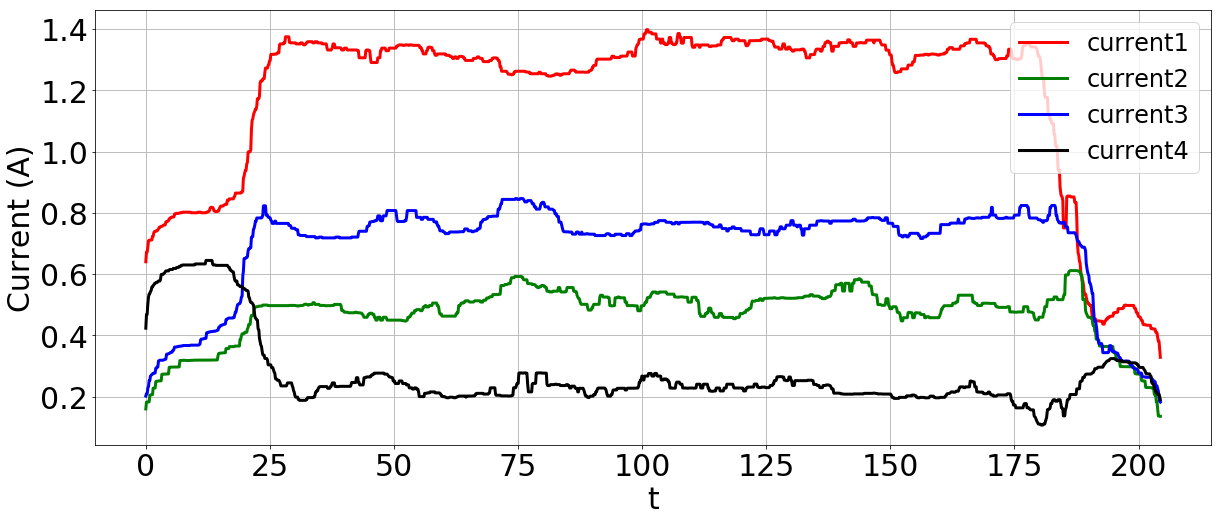

In [14]:
fig = plt.figure(figsize=(20, 8))
plt.plot(nominal_timestamps - nominal_timestamps[0], DataUtils.filter_data(train_data_sw1, window_size=5), 'r', label='current1', linewidth=3)
plt.plot(nominal_timestamps - nominal_timestamps[0], DataUtils.filter_data(train_data_sw2, window_size=5), 'g', label='current2', linewidth=3)
plt.plot(nominal_timestamps - nominal_timestamps[0], DataUtils.filter_data(train_data_sw3, window_size=5), 'b', label='current3', linewidth=3)
plt.plot(nominal_timestamps - nominal_timestamps[0], DataUtils.filter_data(train_data_sw4, window_size=5), 'k', label='current4', linewidth=3)

plt.xlabel('t', fontsize=30)
plt.ylabel('Current (A)', fontsize=30)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.legend(fontsize=24)
plt.grid()
plt.show()

The test data look as shown below:

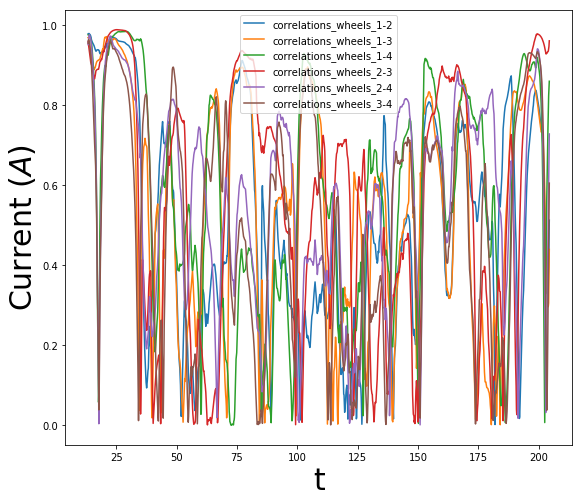

In [15]:
fig = plt.figure(figsize=(20, 8))

data_labels = []
for i in range(number_of_smart_wheels):
    for j in range(i+1, number_of_smart_wheels):
        label = 'correlations_wheels_{0}-{1}'.format(i+1, j+1)
        data_labels.append(label)

PlotUtils.subplot_data_lists(fig=fig, subplot_params=(1,2,1),
                             timestamps=nominal_timestamps[99:]-nominal_timestamps[0],
                             data=windowed_correlations.T,
                             x_label='t', y_label='Current ($A$)',
                             data_labels=data_labels)

plt.show()

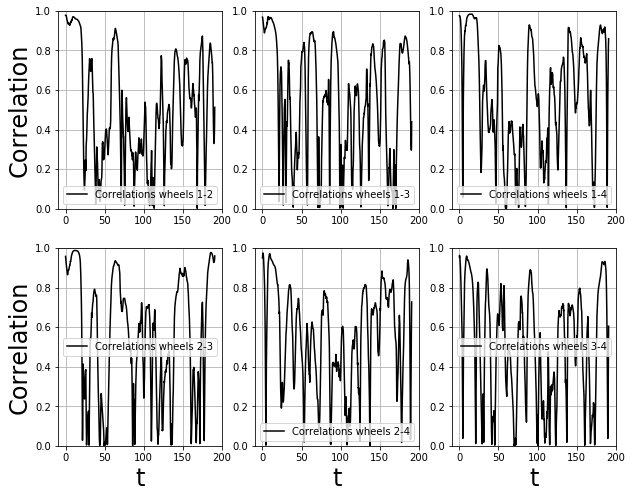

In [16]:
data_labels = []
for i in range(number_of_smart_wheels):
    for j in range(i+1, number_of_smart_wheels):
        label = 'Correlations wheels {0}-{1}'.format(i+1, j+1)
        data_labels.append(label)

fig = plt.figure(figsize=(10, 8))
for i in range(6):
    fig.add_subplot(2, 3, i+1)
    plt.plot(nominal_timestamps[99:] - nominal_timestamps[99],
             windowed_correlations[i], 'k', label=data_labels[i])

    if i >= 3:
        plt.xlabel('t', fontsize=24)

    if i % 3 == 0:
        plt.ylabel('Correlation', fontsize=24)
    plt.ylim([0, 1])
    plt.legend()
    plt.grid()
plt.show()

The faulty test data are also all voltage measurements, but in a sequence with an injected fault.

In [17]:
faulty_sw_data_docs = DBUtils.get_all_docs(faulty_log_db_data_name,
                                           'ros_sw_ethercat_parser_data')
faulty_timestamps = DataUtils.get_all_measurements(faulty_sw_data_docs, 'timestamp')

faulty_test_data_sw1 = DataUtils.get_all_measurements(faulty_sw_data_docs,
                                                      'sensors/0/current_1_q',
                                                      data_filter=Filters.MEDIAN,
                                                      filter_window_size=101)
faulty_test_data_sw2 = DataUtils.get_all_measurements(faulty_sw_data_docs,
                                                      'sensors/1/current_1_q',
                                                      data_filter=Filters.MEDIAN,
                                                      filter_window_size=101)
faulty_test_data_sw3 = DataUtils.get_all_measurements(faulty_sw_data_docs,
                                                      'sensors/2/current_1_q',
                                                      data_filter=Filters.MEDIAN,
                                                      filter_window_size=101)
faulty_test_data_sw4 = DataUtils.get_all_measurements(faulty_sw_data_docs,
                                                      'sensors/3/current_1_q',
                                                      data_filter=Filters.MEDIAN,
                                                      filter_window_size=101)

faulty_data = np.vstack((faulty_test_data_sw1, faulty_test_data_sw2,
                         faulty_test_data_sw3, faulty_test_data_sw4))

var_names = ['current1', 'current2', 'current3', 'current4']
(corr_vars, faulty_windowed_correlations) = DataUtils.get_windowed_correlations(var_names, faulty_data, window_size=100)

In [18]:
event_docs = DBUtils.get_all_docs(faulty_log_db_data_name, 'ros_ropod_event')
event_timestamps = DataUtils.get_all_measurements(event_docs, 'timestamp')

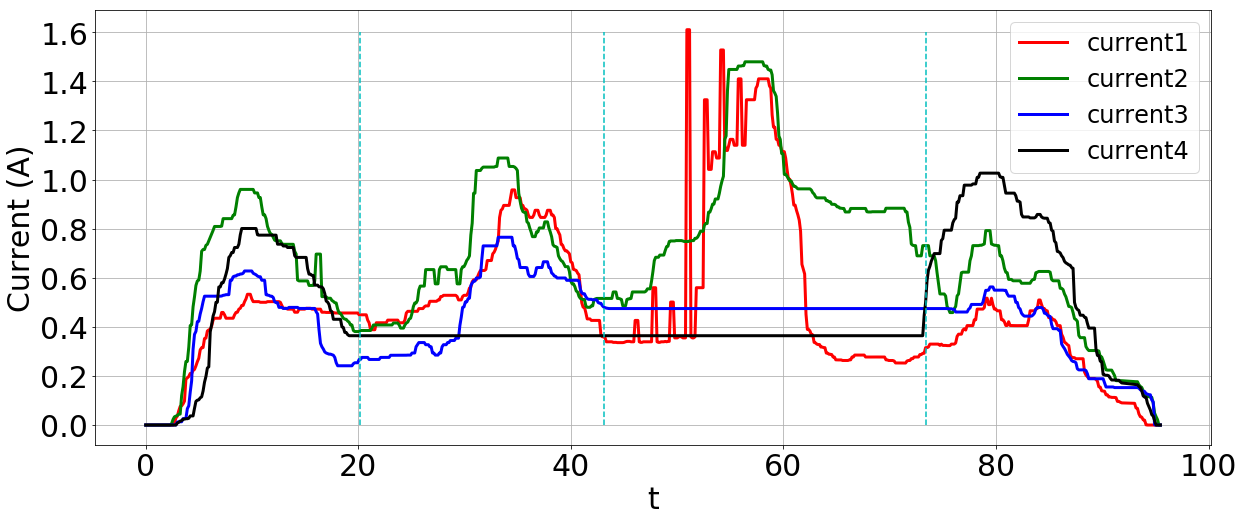

In [19]:
fig = plt.figure(figsize=(20, 8))
plt.plot(faulty_timestamps - faulty_timestamps[0], DataUtils.filter_data(faulty_test_data_sw1, window_size=5), 'r', label='current1', linewidth=3)
plt.plot(faulty_timestamps - faulty_timestamps[0], DataUtils.filter_data(faulty_test_data_sw2, window_size=5), 'g', label='current2', linewidth=3)
plt.plot(faulty_timestamps - faulty_timestamps[0], DataUtils.filter_data(faulty_test_data_sw3, window_size=5), 'b', label='current3', linewidth=3)
plt.plot(faulty_timestamps - faulty_timestamps[0], DataUtils.filter_data(faulty_test_data_sw4, window_size=5), 'k', label='current4', linewidth=3)

plt.plot([event_timestamps-faulty_timestamps[0]-3.5, event_timestamps-faulty_timestamps[0]-3.5], [0, 1.6], 'c--')

plt.xlabel('t', fontsize=30)
plt.ylabel('Current (A)', fontsize=30)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.legend(fontsize=24)
plt.grid()
plt.show()

The faulty test data are plotted below:

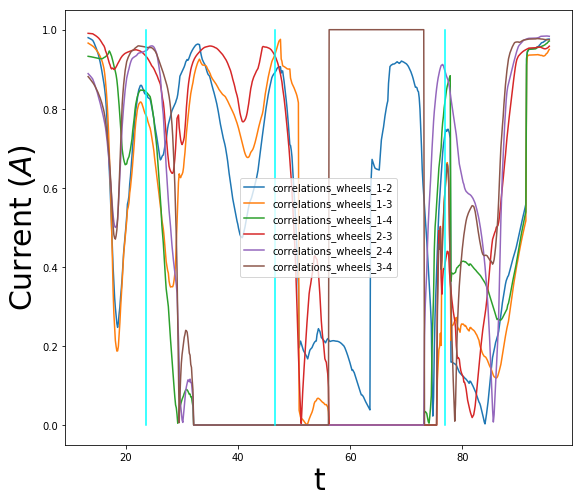

In [20]:
fig = plt.figure(figsize=(20, 8))

data_labels = []
for i in range(number_of_smart_wheels):
    for j in range(i+1, number_of_smart_wheels):
        label = 'correlations_wheels_{0}-{1}'.format(i+1, j+1)
        data_labels.append(label)

PlotUtils.subplot_data_lists(fig=fig, subplot_params=(1,2,1),
                             timestamps=faulty_timestamps[99:]-faulty_timestamps[0],
                             data=faulty_windowed_correlations.T,
                             x_label='t', y_label='Current ($A$)',
                             data_labels=data_labels,
                             event_timestamps=event_timestamps-faulty_timestamps[0],
                             event_annotation_color='cyan')

plt.show()

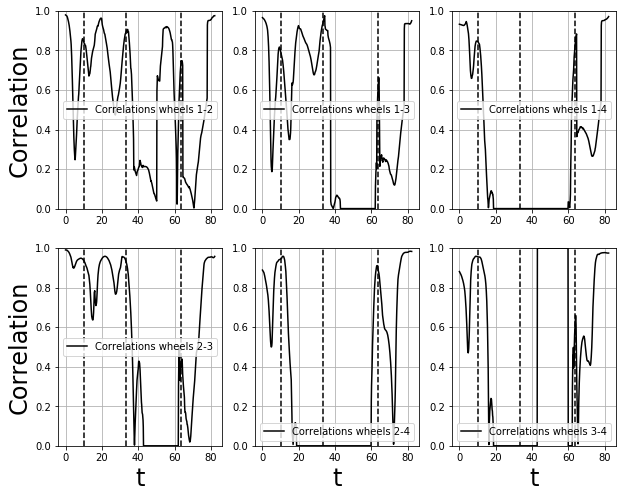

In [21]:
data_labels = []
for i in range(number_of_smart_wheels):
    for j in range(i+1, number_of_smart_wheels):
        label = 'Correlations wheels {0}-{1}'.format(i+1, j+1)
        data_labels.append(label)

fig = plt.figure(figsize=(10, 8))
for i in range(6):
    fig.add_subplot(2, 3, i+1)
    plt.plot([], [], 'k--')
    plt.plot([event_timestamps-faulty_timestamps[99], event_timestamps-faulty_timestamps[99]], [0, 1],
             'k--')
    plt.plot(faulty_timestamps[99:]-faulty_timestamps[99], 
             faulty_windowed_correlations[i], 'k', label=data_labels[i])

    if i >= 3:
        plt.xlabel('t', fontsize=24)

    if i % 3 == 0:
        plt.ylabel('Correlation', fontsize=24)
    plt.ylim([0, 1])
    plt.legend()
    plt.grid()
plt.show()

# Model definition and training

An implementation of a (potentially deep) belief network is given below.

In [22]:
from typing import Sequence

class DBN(object):
    def __init__(self, number_visible_units: int=1,
                 number_hidden_units: Sequence[int]=1,
                 layers: int=1):
        """Creates an architecture for a deep belief network.

        Keyword arguments:
        number_visible_units: int -- an integer denoting the number
                                     of visible units in the network
        number_hidden_units: int -- a list containing the numbers of
                                    hidden units at each level
                                    of the network
        layers: int -- the number of layers in the network
                       (default 1, resulting in a single
                       restricted Boltzmann machine)

        """
        self.neuron_values = []
        self.biases = []
        self.connection_weights = []

        self.number_visible_units = number_visible_units
        self.number_hidden_units = list(number_hidden_units)
        self.layers = layers

        self.neuron_values.append(np.zeros(number_visible_units))
        self.neuron_values.append(np.zeros(number_hidden_units[0]))
        self.biases.append(np.random.rand(number_visible_units))
        self.biases.append(np.random.rand(number_hidden_units[0]))

        #we initialise the connection weights randomly
        # and scale them to the range (0,0.05)
        self.connection_weights.append(np.random.rand(number_visible_units,
                                                      number_hidden_units[0]) * 0.05)

        for i in range(1,layers):
            self.neuron_values.append(np.zeros(number_hidden_units[i]))
            self.biases.append(np.random.rand(number_hidden_units[i]))

            weights = np.random.rand(number_hidden_units[i-1],number_hidden_units[i]) * 0.05
            self.connection_weights.append(weights)

    def train(self, data: np.array, epochs: int=100, learning_rate: float=0.1):
        """Trains the belief network with a given set of training vectors.

        Keyword arguments:
        data: np.array -- Data for training the RBM.
                          Each row of the array should be
                          a training vector of dimension
                          'self.number_visible_units'
        epochs: int -- the number of iterations of the
                       learning algorithm (default 100)
        learning_rate: float -- the algorithm's learning rate (default 0.1)

        """
        number_training_vectors = data.shape[0]
        for current_layer in range(self.layers):
            print('Training layer {0}'.format(current_layer))
            for epoch in range(epochs):
                print('Epoch {0}'.format(epoch))
                for vector in range(number_training_vectors):
                    np.copyto(self.neuron_values[0],data[vector])

                    #we assign values to all neurons up to the current layer;
                    #if we are training the first layer, no hidden units will be assigned;
                    #if we are training an upper layer, then hidden neurons below it will be assigned values
                    for layer in range(current_layer):
                        for neuron in range(self.number_hidden_units[layer]):
                            prob = self._logistic(np.sum(self.connection_weights[layer][:,neuron] * self.neuron_values[layer]) + self.biases[layer+1][neuron])
                            threshold = np.random.rand()
                            if prob > threshold:
                                self.neuron_values[layer+1][neuron] = 1.
                            else:
                                self.neuron_values[layer+1][neuron] = 0.

                    #we sample from the current layer of the network
                    layer_sample = self._sample_layer(current_layer, 1)

                    #we update the connection weights between the visible and hidden units of the current layer
                    for i in range(self.connection_weights[current_layer].shape[0]):
                        #we update the bias values of the visible units in the current visible layer
                        visible_bias_delta = learning_rate * (self.neuron_values[current_layer][i] - layer_sample[i])
                        self.biases[current_layer][i] = self.biases[current_layer][i] + visible_bias_delta

                        for j in range(self.connection_weights[current_layer].shape[1]):
                            data_expectation = self._logistic(np.sum(self.connection_weights[current_layer][:,j] * self.neuron_values[current_layer]) + self.biases[current_layer+1][j])
                            sample_expectation = self._logistic(np.sum(self.connection_weights[current_layer][:,j] * layer_sample) + self.biases[current_layer+1][j])

                            #we update the connection weight between the i-th visible unit and the j-th hidden unit
                            weight_change_delta = learning_rate * (data_expectation * self.neuron_values[current_layer][i] - sample_expectation * layer_sample[i])
                            self.connection_weights[current_layer][i,j] = self.connection_weights[current_layer][i,j] + weight_change_delta

                            #we update the bias values of the hidden units in the current visible layer
                            hidden_bias_delta = learning_rate * (data_expectation - sample_expectation)
                            self.biases[current_layer+1][j] = self.biases[current_layer+1][j] + hidden_bias_delta

    def sample_network(self, vector: np.array=None) -> np.array:
        """Samples a vector from the network. Returns a numpy
        array containing the sampled values.

        Keyword arguments:
        vector: np.array -- an input vector for the network's visible layer

        """
        if vector is None:
            for i in range(self.number_visible_units):
                self.neuron_values[0][i] = np.random.rand()
        else:
            self.neuron_values[0] = np.array(vector)

        for layer in range(self.layers):
            number_hidden_units = len(self.neuron_values[layer+1])
            for neuron in range(number_hidden_units):
                prob = self._logistic(np.sum(self.connection_weights[layer][:,neuron] * self.neuron_values[layer]) + self.biases[layer+1][neuron])
                self.neuron_values[layer+1][neuron] = prob

        for layer in range(self.layers-1,-1,-1):
            number_visible_units = len(self.neuron_values[layer])
            for neuron in range(number_visible_units):
                prob = self._logistic(np.sum(self.connection_weights[layer][neuron,:] * self.neuron_values[layer+1]) + self.biases[layer][neuron])
                self.neuron_values[layer][neuron] = prob

        return np.array(self.neuron_values[0])

    def _sample_layer(self, layer: int, k: int) -> np.array:
        """Samples a visible vector at the layer-th layer of the network.
        Uses Contrastive Divergence for sampling the values. Returns
        a numpy array containing the sampled values

        Keyword arguments:
        layer: int -- the layer at which we want to sample
        k: int -- the number of samples created by
                  Contrastive Divergence before a sample
                  is accepted

        """
        visible_units = np.array(self.neuron_values[layer])
        hidden_units = np.array(self.neuron_values[layer+1])

        visible_biases = np.array(self.biases[layer])
        hidden_biases = np.array(self.biases[layer+1])

        number_visible_units = len(visible_units)
        number_hidden_units = len(hidden_units)

        for _ in range(k):
            for neuron in range(number_hidden_units):
                prob = self._logistic(np.sum(self.connection_weights[layer][:,neuron] * visible_units) + hidden_biases[neuron])
                hidden_units[neuron] = prob

            for neuron in range(number_visible_units):
                prob = self._logistic(np.sum(self.connection_weights[layer][neuron,:] * hidden_units) + visible_biases[neuron])
                visible_units[neuron] = prob

        return visible_units

    def _logistic(self, x):
        '''Returns the value of f(x) = 1 / (1 + exp(-x))
        '''
        # we prevent under/overflow by cutting of
        # the accepted input of the exponential
        if x < -30:
            return 0.
        elif x > 30:
            return 1.
        return 1. / (1. + np.exp(-x))

We now train our fault detection models:

In [17]:
sequence_len = 10
print('Training wheel 12 model...')
network_w12, arr_min_w12, arr_max_w12 = train(windowed_correlations[0,:],
                                              sequence_len)

print('Training wheel 13 model...')
network_w13, arr_min_w13, arr_max_w13 = train(windowed_correlations[1,:],
                                              sequence_len)

print('Training wheel 14 model...')
network_w14, arr_min_w14, arr_max_w14 = train(windowed_correlations[2,:],
                                              sequence_len)

print('Training wheel 23 model...')
network_w23, arr_min_w23, arr_max_w23 = train(windowed_correlations[3,:],
                                              sequence_len)

print('Training wheel 24 model...')
network_w24, arr_min_w24, arr_max_w24 = train(windowed_correlations[4,:],
                                              sequence_len)

print('Training wheel 34 model...')
network_w34, arr_min_w34, arr_max_w34 = train(windowed_correlations[5,:],
                                              sequence_len)

Training wheel 12 model...
Training layer 0
Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Epoch 10
Epoch 11
Epoch 12
Epoch 13
Epoch 14
Epoch 15
Epoch 16
Epoch 17
Epoch 18
Epoch 19
Epoch 20
Epoch 21
Epoch 22
Epoch 23
Epoch 24
Epoch 25
Epoch 26
Epoch 27
Epoch 28
Epoch 29
Training wheel 13 model...
Training layer 0
Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Epoch 10
Epoch 11
Epoch 12
Epoch 13
Epoch 14
Epoch 15
Epoch 16
Epoch 17
Epoch 18
Epoch 19
Epoch 20
Epoch 21
Epoch 22
Epoch 23
Epoch 24
Epoch 25
Epoch 26
Epoch 27
Epoch 28
Epoch 29
Training wheel 14 model...
Training layer 0
Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Epoch 10
Epoch 11
Epoch 12
Epoch 13
Epoch 14
Epoch 15
Epoch 16
Epoch 17
Epoch 18
Epoch 19
Epoch 20
Epoch 21
Epoch 22
Epoch 23
Epoch 24
Epoch 25
Epoch 26
Epoch 27
Epoch 28
Epoch 29
Training wheel 23 model...
Training layer 0
Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoc

In [18]:
networks = [network_w12, network_w13, network_w14, network_w23, network_w24, network_w34]
mins = [arr_min_w12, arr_min_w13, arr_min_w14, arr_min_w23, arr_min_w24, arr_min_w34]
maxs = [arr_max_w12, arr_max_w13, arr_max_w14, arr_max_w23, arr_max_w24, arr_max_w34]

We now calculate the distances between the test data and the sampled data from the learned models:

In [19]:
distances_no_faults_w1 = list()
for i in range(len(mins)):
    distances_no_faults_w1.append(test(windowed_correlations[i],
                                       mins[i], maxs[i],
                                       networks[i], sequence_len))
distances_no_faults_w1 = np.array(distances_no_faults_w1)

We also calculate the distances between the faulty test data and the sampled data from the learned models:

In [20]:
faulty_distances_w1 = list()
for i in range(len(mins)):
    faulty_distances_w1.append(test(faulty_windowed_correlations[i],
                                    mins[i], maxs[i],
                                    networks[i], sequence_len))
faulty_distances_w1 = np.array(faulty_distances_w1)

We calculate two thresholds based on the distances:
\begin{align*}
    t_{soft} = \mu_D - 3 * \sigma_D \\
    t_{hard} = \max{D}
\end{align*}

here $D$ is the set of distance measurements, $\mu_D$ is the mean distance, and $\sigma_D$ is the standard deviation of the distances.

The reasoning here is that if a wheel has a fault, it will stay in the region between the soft and the hard threshold (or even exceed the hard threshold) longer than if we have a fault positive detection, which should go back to normal relatively quickly.

In [21]:
combined_distances = np.hstack((distances_no_faults_w1,))
fault_thresholds = np.mean(combined_distances, axis=1) + \
                   3 * np.std(combined_distances, axis=1)

The distances on the fault-free test data are shown below; as we can see, there are some fault positive detections, but as hypothesised, the distances leave the faulty region quickly.

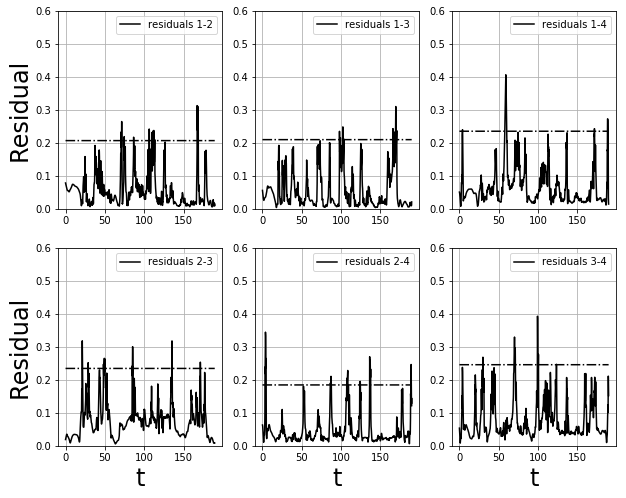

In [22]:
data_labels = []
for i in range(number_of_smart_wheels):
    for j in range(i+1, number_of_smart_wheels):
        label = 'residuals {0}-{1}'.format(i+1, j+1)
        data_labels.append(label)

fig = plt.figure(figsize=(10, 8))
for i in range(6):
    fig.add_subplot(2, 3, i+1)
    plt.plot(nominal_timestamps[109:] - nominal_timestamps[109],
             np.ones(distances_no_faults_w1.shape[1]) * \
                     fault_thresholds[i], 'k-.')
    plt.plot(nominal_timestamps[109:] - nominal_timestamps[109],
             distances_no_faults_w1[i,:], 'k', label=data_labels[i])

    if i >= 3:
        plt.xlabel('t', fontsize=24)

    if i % 3 == 0:
        plt.ylabel('Residual', fontsize=24)

    plt.ylim([0, 0.6])
    plt.legend()
    plt.grid()
plt.show()

The distances on the faulty data are shown below; as expected, the distances remain in the faulty region for a longer period when there is a fault.

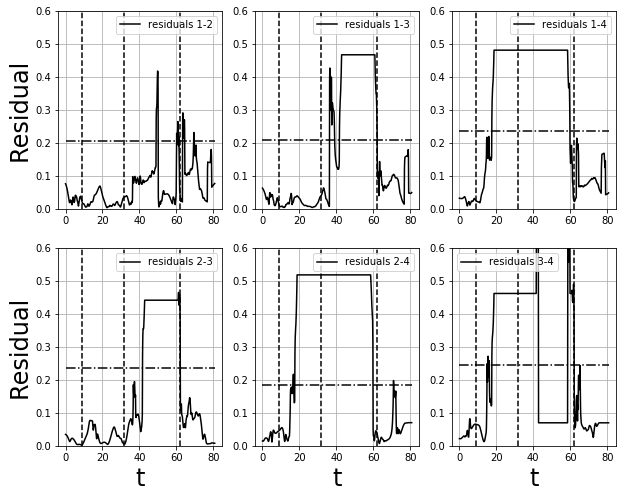

In [35]:
data_labels = []
for i in range(number_of_smart_wheels):
    for j in range(i+1, number_of_smart_wheels):
        label = 'residuals {0}-{1}'.format(i+1, j+1)
        data_labels.append(label)

fig = plt.figure(figsize=(10, 8))
for i in range(6):
    fig.add_subplot(2, 3, i+1)
    plt.plot([event_timestamps-faulty_timestamps[109],
              event_timestamps-faulty_timestamps[109]], [0, 0.6],
             'k--')
    plt.plot(faulty_timestamps[109:]-faulty_timestamps[109],
             np.ones(faulty_distances_w1.shape[1]) * \
                     fault_thresholds[i], 'k-.')
    plt.plot(faulty_timestamps[109:]-faulty_timestamps[109],
             faulty_distances_w1[i,:], 'k', label=data_labels[i])

    if i >= 3:
        plt.xlabel('t', fontsize=24)

    if i % 3 == 0:
        plt.ylabel('Residual', fontsize=24)

    plt.ylim([0, 0.6])
    plt.legend()
    plt.grid()
plt.show()

# Evaluation

In [24]:
total_nominal = 0.
fp = 0.
for i in range(6):
    fp += len(np.where(distances_no_faults_w1[i] > fault_thresholds[i])[0])
    total_nominal += len(distances_no_faults_w1[i])

In [25]:
(fp / total_nominal) * 100.

1.992619926199262

In [36]:
tp_faulty = 0.
fp_faulty = 0.
fn_faulty = 0.
tn_faulty = 0.
fault_timestamps = faulty_timestamps[109:]-faulty_timestamps[109]
norm_event_timestamps = event_timestamps-faulty_timestamps[109]

region_detections = [[2, 4, 5], [1, 2, 3, 4]]
for i, timestamp in enumerate(fault_timestamps):
    subsequent_events = np.where(norm_event_timestamps > timestamp)[0]
    next_event = -1
    if len(subsequent_events) > 0:
        next_event = subsequent_events[0]
    fault_region = next_event - 1

    # we are not in a faulty region, so any
    # detections are false alarms
    if fault_region < 0:
        for j in range(6):
            if faulty_distances_w1[j][i] > fault_thresholds[j]:
                fp_faulty += 1
            else:
                tn_faulty += 1
    else:
        for j in range(6):
            if j in region_detections[fault_region]:
                # we are in a faulty region and we expect
                # detections for the j-th model, so any
                # missing detections are false negatives
                if faulty_distances_w1[j][i] > fault_thresholds[j]:
                    tp_faulty += 1
                else:
                    fn_faulty += 1
            else:
                # we are in a faulty region, but we don't expect
                # detections for the j-th model, so any
                # detections are false positives
                if faulty_distances_w1[j][i] > fault_thresholds[j]:
                    fp_faulty += 1
                else:
                    tn_faulty += 1

In [37]:
print('True positives: {0}'.format(tp_faulty))
print('True negatives: {0}'.format(tn_faulty))
print('False positives: {0}'.format(fp_faulty))
print('False negatives: {0}'.format(fn_faulty))

True positives: 1115.0
True negatives: 2046.0
False positives: 140.0
False negatives: 359.0


In [38]:
precision = tp_faulty / (tp_faulty + fp_faulty)
recall = tp_faulty / (tp_faulty + fn_faulty)

In [39]:
print('Precision: {0}'.format(precision))
print('Recall: {0}'.format(recall))

Precision: 0.8884462151394422
Recall: 0.7564450474898237
